# Top
- Dataset downloaded from Kaggle
- upload to drive in unzip

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [5]:
# unzip compress image files for initial upload to drive
# !unzip "/content/drive/MyDrive/COMP_CV_PJ_FALL23_2nd_edition/datasets/archive (4).zip" -d "/content/drive/MyDrive/COMP_CV_PJ_FALL23_2nd_edition/datasets/ships"

In [6]:
# import all files from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# import datasets handling
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler

# visualize
from sklearn.decomposition import PCA

# LBP
from skimage import feature

# model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# splitting datasets
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import classification_report,accuracy_score

# plotting
import matplotlib.pyplot as plt

# hog
from skimage.feature import hog

# Define functions

Main stuff
1. convert image data 80x80 into grayscale, normalized, np form  
2. generate the lbp and hog representation of each images

In [8]:
# read image dataset from google drive, then return X and Y dataset
def read_images(path):

  # List all files in the folder check number of files exist in that path
  files = os.listdir(path_dtset)
  print(f"Number of images in the folder: {len(files)}")

  # prepare x and y container to store actual images and labels
  # labels are noted in image name || e.g 0_.jpg -> ships not present.
  X = []
  Y = []
  # iterate each images and add them to array
  for image_file_name in files:
    img = cv2.imread(path_dtset + '/' +str(image_file_name), 0)
    X.append(img)
    if str(image_file_name[0]) == "0" :
      Y.append(0)
    else :
      Y.append(1)

  # convert array to numpy array type for easier manipulation in models
  X = np.array(X)
  Y = np.array(Y)

  # verify correctness on X and Y
  print("x dataset type :",type(X))
  print("y dataset type",type(Y))
  print(" shape X :",X.shape," shape Y :",Y.shape)

  return X, Y

# pick 1 image from dataset and show with its label
def show_image_with_label(image, label):

    # Display the image
    plt.imshow(image, cmap='gray')  # Assuming the image is grayscale
    plt.title(f'Label: {label}')

    # Show plot
    plt.show()

# normalize input pixel values for improving description
def normalize_pixelvalues(X):

  # normalize all pixel values in [0,255]
  X = X/255.0

  # validate normalization
  print(f"Minimum value: {np.min(X)}")
  print(f"Maximum value: {np.max(X)}")

  return X

# get lbp representation of images dataset
def get_lbp(X,numPoints,radius):

  # list to store extracted features of an image
  lbp_features = []

  # iterate images
  for image in X:

    # return 2d array of our image applied with lbp
    lbp = feature.local_binary_pattern(image, numPoints,radius)#,method="uniform")

    # return feature vector(histogram)
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3),range=(0, numPoints + 2))

    # normalize each  histogram
    eps = 1e-7
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)

    #a add normalize histogram to lbp_features list
    lbp_features.append(hist)


  # return all lbp representation of images'
  return lbp_features
# -- notes --
# histogram is a representation of the texture characteristics
# 2 images have same distribution in hist, if their texture look alike. e.g. dots

# plot histogram of lbp for single sample image to verify correctness
def plot_lbp(lbp_feature_vector, ax):
    # Plotting a histogram
    ax.hist(lbp_feature_vector, color='skyblue', edgecolor='black')
    ax.set_title('LBP Feature Vector')
    ax.set_xlabel('LBP Values')
    ax.set_ylabel('Frequency')

# generat train test set
def generate_train_test(X,Y,test_size):
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y,test_size=test_size,shuffle=True)
    print("x train shape", len(xtrain))
    print("y test shape", len(ytest))
    print("take 1st sample from x train", xtrain[0])
    print("take 1st sample from y test", ytest[0])

    return xtrain, xtest, ytrain, ytest

# generate hog version of X image dataset and return
def hog_features(X, pixels_per_cell,cells_per_block):
    # a list to store feature vector for each images
    feature_vector_list = []
    # store hog applied image
    hog_img_list = []

    # iterate thru each images
    for image in X:
      # generate hog vector and hog 2d image array for each images
      fv, hog_img = hog(image, orientations=9, pixels_per_cell=pixels_per_cell,visualize=True,block_norm='L2')
      feature_vector_list.append(fv)
      hog_img_list.append(hog_img)

    # return a list of feature vectors and 2d array
    return np.array(feature_vector_list), hog_img_list
# notes
# counts occurrences of gradient orientation in the localized portion of an image
# Gradient orientation refers to the direction in which the intensity or color of an image changes most rapidly at a particular point.
# e.g. in our case ship towards top right, 45 degree has the most

In [9]:
# for plotting results

def plot_hog_features_vectors(hog_feature1, hog_feature2, hog_feature3, hog_feature4):
    fig, axs = plt.subplots(1, 4, figsize=(15, 3))  # Adjust the figsize as needed

    # Plot for the first HOG feature
    axs[0].scatter(range(len(hog_feature1)), hog_feature1, color='red')
    axs[0].set_title('HOG Feature 1')

    # Plot for the second HOG feature
    axs[1].scatter(range(len(hog_feature2)), hog_feature2, color='blue')
    axs[1].set_title('HOG Feature 2')

    # Plot for the third HOG feature
    axs[2].scatter(range(len(hog_feature3)), hog_feature3, color='green')
    axs[2].set_title('HOG Feature 3')

    # Plot for the fourth HOG feature
    axs[3].scatter(range(len(hog_feature4)), hog_feature4, color='purple')
    axs[3].set_title('HOG Feature 4')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Start

In [41]:
# returns X: set of images where each image size  80 x 80
# Y : 1d array of ones/zeros
path_dtset = '/content/drive/MyDrive/COMP_CV_PJ_FALL23_2nd_edition/datasets/ships/shipsnet/shipsnet'
X, Y = read_images(path_dtset)

Number of images in the folder: 4000
x dataset type : <class 'numpy.ndarray'>
y dataset type <class 'numpy.ndarray'>
 shape X : (4000, 80, 80)  shape Y : (4000,)


In [42]:
# normalize each images to bound between 0 and 1 by dividing 255
X = normalize_pixelvalues(X)

Minimum value: 0.00392156862745098
Maximum value: 1.0


In [43]:
# convert list to numpy format
X= np.array(X)
print(X.shape)

(4000, 80, 80)


# PCA fit

## Visualize

Text(0.5, 1.0, '4.Label: 1')

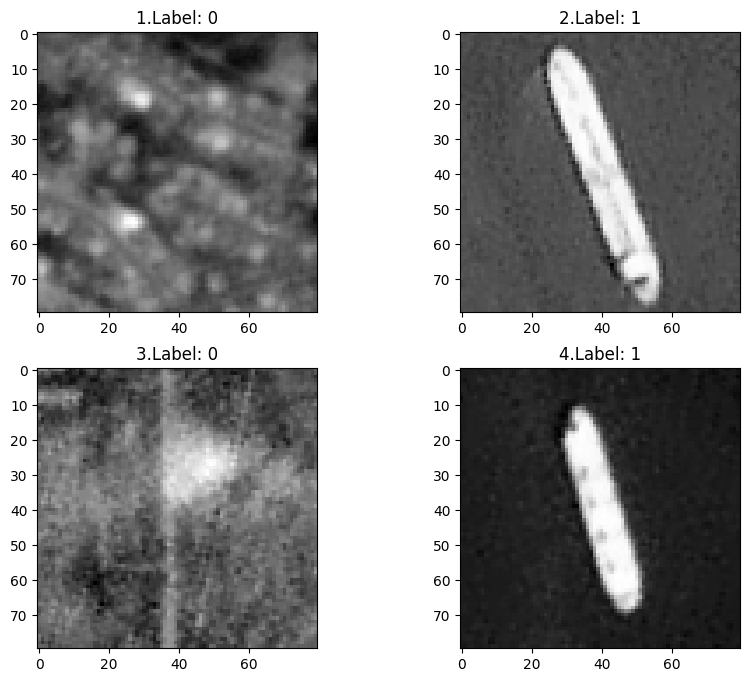

In [44]:
# Choose the index of the image you want to display
index_to_display_1 = 3901
index_to_display_2 = 100
index_to_display_3 = 3907
index_to_display_4 = 902

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Show images with labels in each subplot
axs[0, 0].imshow(X[index_to_display_1], cmap='gray')
axs[0, 0].set_title(f'1.Label: {Y[index_to_display_1]}')
axs[0, 1].imshow(X[index_to_display_2], cmap='gray')
axs[0, 1].set_title(f'2.Label: {Y[index_to_display_2]}')
axs[1, 0].imshow(X[index_to_display_3], cmap='gray')
axs[1, 0].set_title(f'3.Label: {Y[index_to_display_3]}')
axs[1, 1].imshow(X[index_to_display_4], cmap='gray')
axs[1, 1].set_title(f'4.Label: {Y[index_to_display_4]}')

we see 2nd and 4th have a bit similar pattern.


In [45]:
# reshape our image dataset 2d part to 1d, so PCA can process fa
data_reshaped_x =  X.reshape(4000, -1)
data_reshaped_x.shape

(4000, 6400)

## PCA

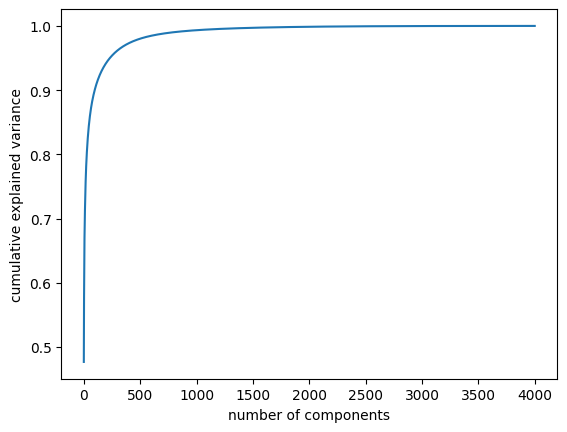

In [46]:
# Choosing the optimal number of components st it covers the maximum variability of our data.
pca = PCA().fit(data_reshaped_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [86]:
# get the calculated reduced X features(PCA feature) using optimal number of components
pca = PCA(n_components=800)
optimal_features_pca_X = pca.fit_transform(data_reshaped_x)

In [87]:
# check the reduced X
optimal_features_pca_X.shape

(4000, 800)

we see first component has high variance with 0.47


In [ ]:
# get variance coverage for each component
pca.explained_variance_ratio_

In [89]:
# generate train test set. shuffle is assumed
xtrain, xtest, ytrain, ytest = generate_train_test(optimal_features_pca_X,Y,test_size=0.2)

x train shape 3200
y test shape 800
take 1st sample from x train [-4.52151821e+00 -2.55777882e+00  4.15759907e-01  9.16202970e-01
 -6.32935741e-02 -3.79212083e-01 -4.50841172e-01  4.83001514e-01
 -3.36533491e-01 -3.25307849e-01 -1.19775616e-01  2.05057808e-01
  5.26494502e-01 -4.20973391e-01 -1.22325531e+00 -1.00569760e-03
 -4.37416967e-01 -6.56252272e-01 -1.27935085e-01  3.52155069e-01
 -1.21101938e+00  3.67471234e-03  2.82203042e-01  9.85116845e-01
 -6.31947196e-01  5.64217866e-01  3.22596415e-02 -1.15292529e-01
  2.58655107e-02  4.97461733e-01 -1.80451547e-01 -1.34798361e-01
  2.14879550e-01 -1.46305183e-02 -2.04656107e-01  6.48737747e-02
 -1.16243102e-01  1.71290724e-01  4.65661918e-02  5.57980265e-01
 -4.76632467e-02 -2.30595994e-01 -2.03477599e-01 -4.59860224e-02
  4.22197315e-01 -2.99633077e-02 -3.99451323e-01 -1.03048502e-01
  6.99146738e-02  5.65625383e-01  1.47791254e-02 -5.09746490e-01
  7.62884801e-01  2.27448211e-01  2.25103451e-01  2.54925365e-01
  2.46186038e-01  1.06085

Text(0, 0.5, 'PC3')

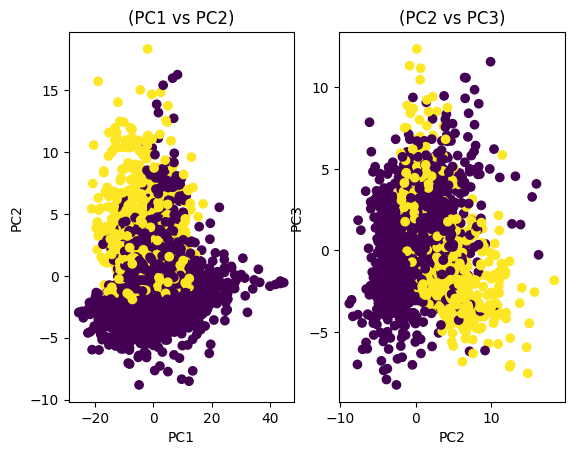

In [90]:
# Plot the first subplot (PC1 vs PC2)
plt.subplot(1, 2, 1)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, cmap='viridis')
plt.title('(PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Plot the second subplot (PC2 vs PC3)
plt.subplot(1, 2, 2)
plt.scatter(xtrain[:, 1], xtrain[:, 2], c=ytrain, cmap='viridis')
plt.title('(PC2 vs PC3)')
plt.xlabel('PC2')
plt.ylabel('PC3')

## fit

In [91]:
# define linear svc model
model_svc =  SVC(kernel='linear',C=0.9,max_iter=100)
model_svc.fit(xtrain, ytrain)

# do a prediction
y_pred_svc = model_svc.predict(xtest)

# get accuracy of lbp
print("LBP Accuracy: "+str(accuracy_score(ytest, y_pred_svc)))
print('\n')
print(classification_report(ytest, y_pred_svc))

LBP Accuracy: 0.74375


              precision    recall  f1-score   support

           0       0.92      0.71      0.80       583
           1       0.52      0.83      0.64       217

    accuracy                           0.74       800
   macro avg       0.72      0.77      0.72       800
weighted avg       0.81      0.74      0.76       800



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [92]:
# define LogisticRegression model
lg_model = LogisticRegression(C=0.9,max_iter=100)
lg_model.fit(xtrain, ytrain)

# do a prediction
y_pred = lg_model.predict(xtest)

# get accuracy on test set of lbp
print("LBP Accuracy: "+str(accuracy_score(ytest, y_pred)))
print('\n')
print(classification_report(ytest, y_pred))

LBP Accuracy: 0.87125


              precision    recall  f1-score   support

           0       0.91      0.91      0.91       583
           1       0.76      0.77      0.76       217

    accuracy                           0.87       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.87      0.87      0.87       800



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
# define MLPClassifier
# we have 10 features from lbp feature vectors, thus inputs are size 10
est = MLPClassifier(hidden_layer_sizes=(10,10),activation='relu')

# fit model on lbp datasets
est.fit(xtrain, ytrain)
y_pred = est.predict(xtest)
print(accuracy_score(ytest,y_pred))

# get accuracy on test set of lbp
print("LBP Accuracy: "+str(accuracy_score(ytest, y_pred)))
print('\n')
print(classification_report(ytest, y_pred))

0.93
LBP Accuracy: 0.93


              precision    recall  f1-score   support

           0       0.96      0.94      0.95       583
           1       0.85      0.89      0.87       217

    accuracy                           0.93       800
   macro avg       0.91      0.92      0.91       800
weighted avg       0.93      0.93      0.93       800



# HOG fit

## Visualize

In [94]:
X.shape

(4000, 80, 80)

Text(0.5, 1.0, '4.Label: 1')

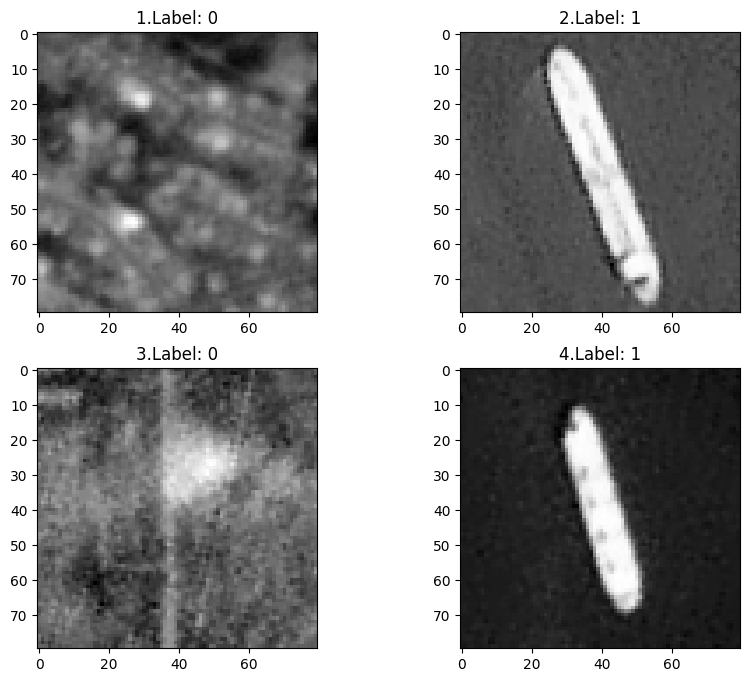

In [95]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# Show images with labels in each subplot
axs[0, 0].imshow(X[index_to_display_1], cmap='gray')
axs[0, 0].set_title(f'1.Label: {Y[index_to_display_1]}')
axs[0, 1].imshow(X[index_to_display_2], cmap='gray')
axs[0, 1].set_title(f'2.Label: {Y[index_to_display_2]}')
axs[1, 0].imshow(X[index_to_display_3], cmap='gray')
axs[1, 0].set_title(f'3.Label: {Y[index_to_display_3]}')
axs[1, 1].imshow(X[index_to_display_4], cmap='gray')
axs[1, 1].set_title(f'4.Label: {Y[index_to_display_4]}')

## HOG

In [96]:
# number of pixels to define in a cell
pixels_per_cell = (8,8)
# define number of local neigbhoring size
# e.g if we have 9 bins in each cell. we collect 9x4 = 36 feature vectors
cells_per_block = (2,2)

# return a list of feature vectors and 2d array
hog_x, hog_images_2d_arr = hog_features(X, pixels_per_cell,cells_per_block)

In [98]:
# check shape of return feature vectors
hog_x.shape

(4000, 5184)

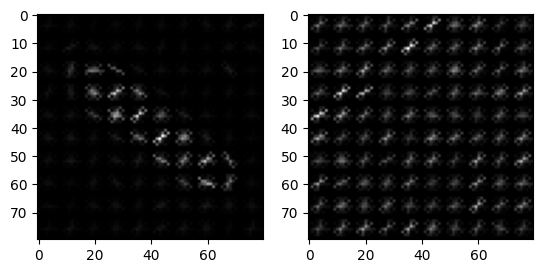

In [102]:
# plot 2 hog version training images
index_to_display_h1 = 900
index_to_display_h2 = 1000

plt.subplot(121)
plt.imshow(hog_images_2d_arr[index_to_display_h1], cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(hog_images_2d_arr[index_to_display_h2], cmap=plt.cm.gray)

(array([2.027e+03, 1.881e+03, 8.570e+02, 2.770e+02, 8.200e+01, 3.400e+01,
        1.300e+01, 5.000e+00, 6.000e+00, 2.000e+00]),
 array([0.        , 0.06094638, 0.12189276, 0.18283914, 0.24378552,
        0.3047319 , 0.36567828, 0.42662466, 0.48757104, 0.54851742,
        0.6094638 ]),
 <BarContainer object of 10 artists>)

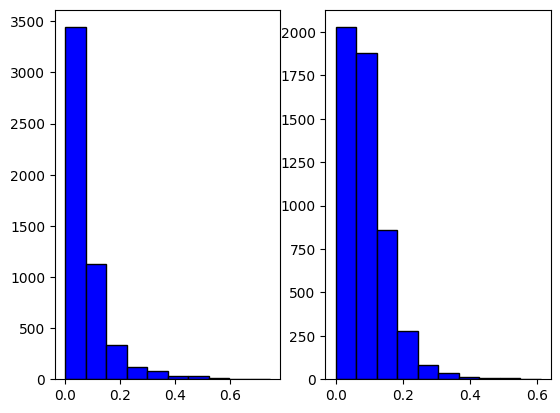

In [104]:
# plot hog distribution of 2 training images
# histogram represents distribution of gradient orientations
plt.subplot(121)
plt.hist(hog_x[index_to_display_h1], color='blue', edgecolor='black')
plt.subplot(122)
plt.hist(hog_x[index_to_display_h2], color='blue', edgecolor='black')

In [111]:
# generate hog version train test set
hog_xtrain, hog_xtest, hog_ytrain, hog_ytest =  generate_train_test(hog_x,Y,test_size=0.2)

x train shape 3200
y test shape 800
take 1st sample from x train [0.24586696 0.13845562 0.01901004 ... 0.1502094  0.11429902 0.07012134]
take 1st sample from y test 0


In [112]:
hog_xtrain.shape

(3200, 5184)

## Fit

In [113]:
# define linear svc model
hog_svc =  SVC(kernel='linear',C=0.9,max_iter=100)
hog_svc.fit(hog_xtrain, hog_ytrain)

# do a prediction
hog_y_pred = hog_svc.predict(hog_xtest)

# get accuracy of lbp
print("LBP Accuracy: "+str(accuracy_score(hog_ytest, hog_y_pred)))
print('\n')
print(classification_report(hog_ytest, hog_y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


LBP Accuracy: 0.97375


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       596
           1       0.93      0.97      0.95       204

    accuracy                           0.97       800
   macro avg       0.96      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



In [114]:
# define LogisticRegression model
model = LogisticRegression(C=0.9,max_iter=100)

model.fit(hog_xtrain, hog_ytrain)

# do a prediction
hog_y_pred = model.predict(hog_xtest)

# get accuracy of lbp
print("LBP Accuracy: "+str(accuracy_score(hog_ytest, hog_y_pred)))
print('\n')
print(classification_report(hog_ytest, hog_y_pred))

LBP Accuracy: 0.99


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       596
           1       0.98      0.99      0.98       204

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [115]:
# define MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(10,10),activation='relu')

# fit model
model.fit(hog_xtrain, hog_ytrain)

# do a prediction
hog_y_pred = model.predict(hog_xtest)

# get accuracy of lbp
print("LBP Accuracy: "+str(accuracy_score(hog_ytest, hog_y_pred)))
print('\n')
print(classification_report(hog_ytest, hog_y_pred))

LBP Accuracy: 0.98875


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       596
           1       0.97      0.99      0.98       204

    accuracy                           0.99       800
   macro avg       0.98      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



result hog

# Additional : CNN

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, AveragePooling2D
from keras import backend as K

In [ ]:
# Define a network as a linear stack of layers
model = Sequential()

# Add 1st convolutional layer with:
    # - features maps: 6
    # - kernel shape: 5 x 5
    # - activation function post-convolution: hyperbolic tanget (tanh)
model.add(Conv2D(filters=6,kernel_size=(5,5),
                activation='tanh',
                input_shape=(80,80,1)))

# Add 1st pooling layer with kernel shape: 2 x 2
model.add(AveragePooling2D(pool_size=(2, 2)))

# Add 2st convolutional layer with:
    # - features maps: 16
    # - kernel shape: 5 x 5
    # - activation function post-convolution: hyperbolic tanget (tanh)
model.add(Conv2D(filters=16,kernel_size=(5,5),
                activation='tanh'))

# Add 2st pooling layer with kernel shape: 2 x 2
model.add(AveragePooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add 1st fully-connected layer with sigmoid activation function
model.add(Dense(120, activation='sigmoid'))

# Add 2st fully-connected layer with sigmoid activation function
model.add(Dense(84, activation='sigmoid'))

# Add output layer with softmax activation with 10 output classes
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 76, 76, 6)         156       
                                                                 
 average_pooling2d_2 (Avera  (None, 38, 38, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 34, 34, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 17, 17, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 4624)              0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [ ]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
# optimizer=optimizers.RMSprop(learning_rate=1e-4),
metrics=['acc'])

In [ ]:
import cv2
import os
path_dtset = '/content/drive/MyDrive/COMP_CV_PJ_FALL23_2nd_edition/datasets/ships/shipsnet/shipsnet'

files = os.listdir(path_dtset)

X = []
Y = []
for image_file_name in files:
  img = cv2.imread(path_dtset + '/' +str(image_file_name), 0)
  X.append(img)
  if str(image_file_name[0]) == "0" :
    Y.append(0)
  else :
    Y.append(1)

In [ ]:
X = np.array(X)
Y = np.array(Y)

X = X/255

In [ ]:
X.shape

(4000, 80, 80)

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y,test_size=.20,shuffle=True)

In [ ]:
xtrain.shape, xtest.shape

((3200, 80, 80), (800, 80, 80))

In [ ]:
history = model.fit(xtrain, ytrain, batch_size = 128 ,epochs = 100 , validation_data = (xtest, ytest) )

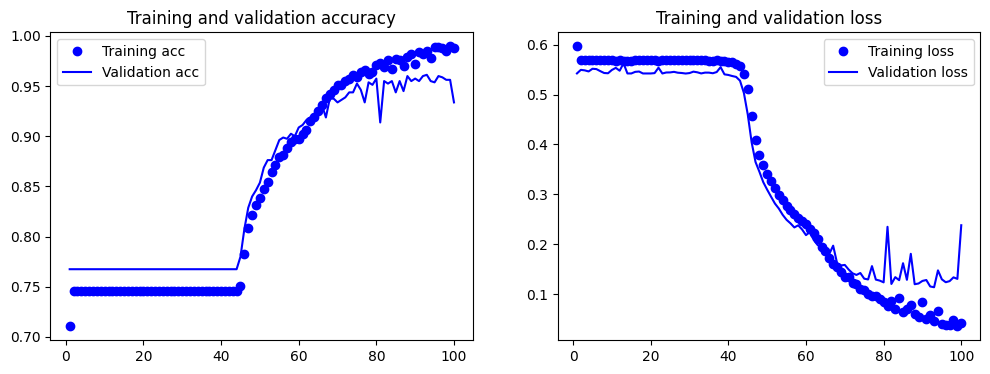

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the width (12) and height (4) as needed

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
axs[0].plot(epochs, acc, 'bo', label='Training acc')
axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(epochs, loss, 'bo', label='Training loss')
axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].legend()

# Display the plots
plt.show()